# B0006 잔여 수명 예측 (시간 순서 교차 검증 버전)

이 노트북은 B0006 배터리의 방전 사이클을 이용해 PyTorch LSTM 모델로 잔여 수명(RUL)을 예측합니다.
앞선 기본 버전에서 제기된 `검증 셋이 말기 구간만 포함되어 상수 예측이 만들어지는 문제`를 완화하기 위해
슬라이딩 윈도우 기반의 시계열 교차 검증과 저 RUL 구간 가중치, 용량 동시 예측(멀티태스크)을 도입했습니다.

## 구성 개요

- 데이터 준비 및 시각화
- 방전 사이클 시계열 보간 및 정규화
- 슬라이딩 윈도우 기반 시계열 교차 검증 분할
- PyTorch LSTM 멀티태스크 모델 (RUL + Capacity)
- 저 RUL 구간 가중치가 적용된 학습 루프
- 폴드별 검증 결과 취합 및 시각화 준비

In [141]:
# 기본 라이브러리 및 PyTorch 모듈 불러오기
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")


In [142]:
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)


In [143]:
# 메타데이터 읽기 및 타깃 배터리 선택
DATA_ROOT = Path("cleaned_dataset")
META_PATH = DATA_ROOT / "metadata.csv"

meta = pd.read_csv(META_PATH)
battery_id = "B0006"

battery_meta = (
    meta[(meta["type"] == "discharge") & (meta["battery_id"] == battery_id)]
    .sort_values("start_time")
    .reset_index(drop=True)
)

# 숫자형 열 강제 변환 (용량 및 임피던스 정보)
for col in ["Capacity", "Re", "Rct"]:
    battery_meta[col] = pd.to_numeric(battery_meta[col], errors="coerce")

# 사이클 인덱스와 RUL(남은 사이클 수) 정의
battery_meta["cycle_index"] = np.arange(len(battery_meta))
battery_meta["rul_cycle"] = len(battery_meta) - battery_meta["cycle_index"] - 1

print(f"사이클 수: {len(battery_meta)}")
display(battery_meta.head())
display(battery_meta.tail())


사이클 수: 168


,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_index,rul_cycle
0,discharge,[2.0080e+03 4.0000e+00 1.9000e+01 1.3000e+01 1...,24,B0006,53,4558,04558.csv,1.924246,NaN,NaN,0,167
1,discharge,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...,24,B0006,1,4506,04506.csv,2.035338,NaN,NaN,1,166
2,discharge,[2.0080e+03 4.0000e+00 2.0000e+00 1.9000e+01 4...,24,B0006,3,4508,04508.csv,2.025140,NaN,NaN,2,165
3,discharge,[2.0080e+03 4.0000e+00 2.3000e+01 1.0000e+00 1...,24,B0006,93,4598,04598.csv,1.855277,NaN,NaN,3,164
4,discharge,[2.0080e+03 4.0000e+00 2.3000e+01 2.1000e+01 2...,24,B0006,109,4614,04614.csv,1.797102,NaN,NaN,4,163


,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_index,rul_cycle
163,discharge,[2008. 5. 17. 12. 21. 15.89],24,B0006,444,4949,04949.csv,1.357315,NaN,NaN,163,4
164,discharge,[2008. 5. 22. 16. 17. 58.89],24,B0006,536,5041,05041.csv,1.253231,NaN,NaN,164,3
165,discharge,[2008. 5. 25. 5. 57. 17.89],24,B0006,575,5080,05080.csv,1.205616,NaN,NaN,165,2
166,discharge,[2008. 5. 25. 15. 37. 8.89],24,B0006,583,5088,05088.csv,1.190590,NaN,NaN,166,1
167,discharge,[2008. 5. 5. 11. 41. 31.5],24,B0006,263,4768,04768.csv,1.487632,NaN,NaN,167,0


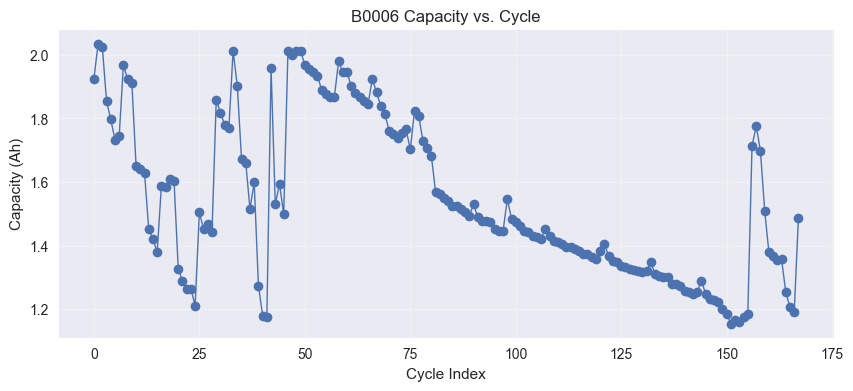

In [144]:
# 용량 감소 추이를 시각화하여 노화 패턴 확인
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(battery_meta["cycle_index"], battery_meta["Capacity"], marker="o", linewidth=1)
ax.set_xlabel("Cycle Index")
ax.set_ylabel("Capacity (Ah)")
ax.set_title(f"{battery_id} Capacity vs. Cycle")
ax.grid(True, alpha=0.3)
plt.show()


In [145]:
# 방전 사이클을 균일 길이로 보간하기 위한 설정 및 함수 정의
SEQ_LEN = 120
FEATURE_COLS = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
]

# 필요시 추가로 참고할 수 있는 스칼라 특성
SCALAR_FEATURES = ["Capacity", "Re", "Rct"]

def load_cycle_sequence(filename: str, seq_len: int = SEQ_LEN) -> np.ndarray:
    """개별 CSV를 불러와 시간축 보간 후 특징 행렬을 반환합니다."""
    path = DATA_ROOT / "data" / filename
    df = pd.read_csv(path).sort_values("Time")
    time = df["Time"].values
    new_time = np.linspace(time.min(), time.max(), seq_len)
    interpolated = []
    for col in FEATURE_COLS:
        interpolated.append(np.interp(new_time, time, df[col].values))
    return np.stack(interpolated, axis=1)


In [146]:
# 모든 방전 사이클을 시퀀스로 변환하고 타깃 벡터 준비
sequences = np.stack([load_cycle_sequence(fname) for fname in battery_meta["filename"]], axis=0)
sequences = sequences.astype(np.float32)

rul_targets = battery_meta["rul_cycle"].astype(np.float32).to_numpy()
capacity_targets = battery_meta["Capacity"].astype(np.float32).to_numpy()

print("시퀀스 배열 형태:", sequences.shape)
print("RUL 범위:", float(rul_targets.min()), float(rul_targets.max()))


시퀀스 배열 형태: (168, 120, 5)
RUL 범위: 0.0 167.0


## 슬라이딩 윈도우 기반 시계열 교차 검증 구성

학습과 검증을 시간 순서를 유지한 채 여러 구간으로 반복합니다.
각 폴드는 일정 길이의 학습 창(train window)과 그 직후 구간을 검증 창으로 사용합니다.
이렇게 하면 초기·중기·말기 구간을 모두 학습에 포함시키며, 검증에서도 다양한 RUL 범위를 확인할 수 있습니다.

In [147]:
# 슬라이딩 윈도우 분할 함수 정의
def build_sliding_folds(total_length: int, train_window: int, val_window: int, step: int):
    folds = []
    start = 0
    while True:
        train_start = start
        train_end = train_start + train_window
        val_end = train_end + val_window
        if val_end > total_length:
            break
        train_idx = np.arange(train_start, train_end)
        val_idx = np.arange(train_end, val_end)
        folds.append((train_idx, val_idx))
        start += step

    # 마지막 구간을 반드시 포함하도록 보정
    if folds:
        last_val_end = folds[-1][1][-1]
        if last_val_end < total_length - 1:
            train_start = max(0, total_length - (train_window + val_window))
            val_start = total_length - val_window
            train_idx = np.arange(train_start, val_start)
            val_idx = np.arange(val_start, total_length)
            if not any(np.array_equal(val_idx, existing_val) for _, existing_val in folds):
                folds.append((train_idx, val_idx))

    return folds

TRAIN_WINDOW = 120
VAL_WINDOW = 12
STEP_WINDOW = 12

fold_indices = build_sliding_folds(len(battery_meta), TRAIN_WINDOW, VAL_WINDOW, STEP_WINDOW)
print(f"생성된 폴드 수: {len(fold_indices)}")
for i, (train_idx, val_idx) in enumerate(fold_indices, 1):
    print(f"Fold {i}: train {train_idx[0]}-{train_idx[-1]}, val {val_idx[0]}-{val_idx[-1]}")


생성된 폴드 수: 4
Fold 1: train 0-119, val 120-131
Fold 2: train 12-131, val 132-143
Fold 3: train 24-143, val 144-155
Fold 4: train 36-155, val 156-167


In [148]:
# PyTorch Dataset 및 데이터 전처리 헬퍼 정의
class CycleDataset(Dataset):
    def __init__(self, x: np.ndarray, rul: np.ndarray, capacity: np.ndarray, weight: np.ndarray | None = None):
        self.x = torch.from_numpy(x)
        self.rul = torch.from_numpy(rul)
        self.capacity = torch.from_numpy(capacity)
        if weight is None:
            weight = np.ones_like(rul, dtype=np.float32)
        self.weight = torch.from_numpy(weight.astype(np.float32))

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int):
        return self.x[idx], self.rul[idx], self.capacity[idx], self.weight[idx]

def compute_norm_stats(train_array: np.ndarray):
    flat = train_array.reshape(-1, train_array.shape[-1])
    mean = flat.mean(axis=0)
    std = flat.std(axis=0) + 1e-6
    return mean, std

def prepare_dataloaders(train_idx, val_idx, batch_size: int = 32, weight_alpha: float = 2.0):
    train_X = sequences[train_idx]
    val_X = sequences[val_idx]

    mean, std = compute_norm_stats(train_X)
    train_X_norm = ((train_X - mean) / std).astype(np.float32)
    val_X_norm = ((val_X - mean) / std).astype(np.float32)

    train_rul = rul_targets[train_idx].astype(np.float32)
    val_rul = rul_targets[val_idx].astype(np.float32)
    train_cap = capacity_targets[train_idx].astype(np.float32)
    val_cap = capacity_targets[val_idx].astype(np.float32)

    max_rul = rul_targets.max()
    train_weight = 1.0 + weight_alpha * (max_rul - train_rul) / max_rul
    val_weight = np.ones_like(val_rul, dtype=np.float32)

    train_dataset = CycleDataset(train_X_norm, train_rul, train_cap, train_weight)
    val_dataset = CycleDataset(val_X_norm, val_rul, val_cap, val_weight)

    loaders = {
        "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    }

    stats = {"mean": mean, "std": std}
    meta = {"train_idx": train_idx, "val_idx": val_idx}
    return loaders, stats, meta


In [149]:
# LSTM 기반 멀티태스크 회귀 모델 정의
class LSTMMultiTask(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.dropout = nn.Dropout(dropout)
        self.head_rul = nn.Linear(hidden_size, 1)
        self.head_capacity = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor):
        output, (hn, _) = self.lstm(x)
        last_hidden = hn[-1]
        last_hidden = self.dropout(last_hidden)
        rul_pred = self.head_rul(last_hidden).squeeze(-1)
        cap_pred = self.head_capacity(last_hidden).squeeze(-1)
        return rul_pred, cap_pred

def weighted_mse(pred: torch.Tensor, target: torch.Tensor, weight: torch.Tensor) -> torch.Tensor:
    return torch.sum(weight * (pred - target) ** 2) / torch.sum(weight)


In [150]:
# 단일 폴드를 학습시키는 함수 정의
def train_single_fold(fold_id: int, loaders: dict, device: torch.device, model_kwargs: dict,
                      optimizer_kwargs: dict, epochs: int, loss_weights: dict[str, float]):
    model = LSTMMultiTask(**model_kwargs).to(device)
    optimizer = torch.optim.Adam(model.parameters(), **optimizer_kwargs)

    history = {"train_loss": [], "val_loss": [], "val_mae": []}
    best_state = None
    best_val = float("inf")

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        train_count = 0
        for xb, y_rul, y_cap, weight in loaders["train"]:
            xb = xb.to(device)
            y_rul = y_rul.to(device)
            y_cap = y_cap.to(device)
            weight = weight.to(device)

            optimizer.zero_grad()
            pred_rul, pred_cap = model(xb)
            loss_rul = weighted_mse(pred_rul, y_rul, weight)
            loss_cap = nn.functional.mse_loss(pred_cap, y_cap)
            loss = loss_weights["rul"] * loss_rul + loss_weights["capacity"] * loss_cap
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            train_count += xb.size(0)

        train_loss /= train_count

        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_count = 0
        with torch.no_grad():
            for xb, y_rul, y_cap, weight in loaders["val"]:
                xb = xb.to(device)
                y_rul = y_rul.to(device)
                y_cap = y_cap.to(device)
                weight = weight.to(device)

                pred_rul, pred_cap = model(xb)
                loss_rul = weighted_mse(pred_rul, y_rul, weight)
                loss_cap = nn.functional.mse_loss(pred_cap, y_cap)
                loss = loss_weights["rul"] * loss_rul + loss_weights["capacity"] * loss_cap

                val_loss += loss.item() * xb.size(0)
                val_mae += torch.sum(torch.abs(pred_rul - y_rul)).item()
                val_count += xb.size(0)

        val_loss /= val_count
        val_mae /= val_count

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_mae"].append(val_mae)

        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()

        if epoch % 5 == 0 or epoch == 1:
            print(f"Fold {fold_id} | Epoch {epoch:02d} | Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Val MAE {val_mae:.3f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    # 검증 예측을 반환
    preds_rul = []
    preds_cap = []
    targets_rul = []
    targets_cap = []
    with torch.no_grad():
        for xb, y_rul, y_cap, _ in loaders["val"]:
            xb = xb.to(device)
            pred_rul, pred_cap = model(xb)
            preds_rul.append(pred_rul.cpu().numpy())
            preds_cap.append(pred_cap.cpu().numpy())
            targets_rul.append(y_rul.numpy())
            targets_cap.append(y_cap.numpy())

    preds_rul = np.concatenate(preds_rul)
    preds_cap = np.concatenate(preds_cap)
    targets_rul = np.concatenate(targets_rul)
    targets_cap = np.concatenate(targets_cap)

    return {
        "model": model,
        "history": history,
        "best_val": best_val,
        "pred_rul": preds_rul,
        "pred_cap": preds_cap,
        "target_rul": targets_rul,
        "target_cap": targets_cap,
    }


In [151]:
# 모든 폴드에 대해 학습 및 검증 실행 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
BATCH_SIZE = 32
LOSS_WEIGHTS = {"rul": 1.0, "capacity": 0.3}
MODEL_KWARGS = {"input_size": len(FEATURE_COLS), "hidden_size": 64, "num_layers": 2, "dropout": 0.2}
OPTIMIZER_KWARGS = {"lr": 1e-3}
WEIGHT_ALPHA = 5.0

fold_results = []
fold_dfs = []

for fold_id, (train_idx, val_idx) in enumerate(fold_indices, 1):
    loaders, stats, meta = prepare_dataloaders(train_idx, val_idx, batch_size=BATCH_SIZE, weight_alpha=WEIGHT_ALPHA)
    result = train_single_fold(fold_id, loaders, DEVICE, MODEL_KWARGS, OPTIMIZER_KWARGS, EPOCHS, LOSS_WEIGHTS)
    result.update({"stats": stats, "meta": meta})
    fold_results.append(result)

    fold_df = battery_meta.iloc[val_idx].copy()
    fold_df = fold_df.assign(
        pred_rul=result["pred_rul"],
        pred_capacity=result["pred_cap"],
        rul_error=result["pred_rul"] - result["target_rul"],
        capacity_error=result["pred_cap"] - result["target_cap"],
    )
    fold_dfs.append(fold_df)

cv_results = pd.concat(fold_dfs).sort_values("cycle_index").reset_index(drop=True)
cv_results[['cycle_index', 'rul_cycle', 'pred_rul', 'rul_error']].head()


Fold 1 | Epoch 01 | Train Loss 10038.9362 | Val Loss 1728.2642 | Val MAE 41.422
Fold 1 | Epoch 05 | Train Loss 9672.3897 | Val Loss 1502.2952 | Val MAE 38.602
Fold 1 | Epoch 10 | Train Loss 8975.1847 | Val Loss 1268.6508 | Val MAE 35.449
Fold 1 | Epoch 15 | Train Loss 8598.9833 | Val Loss 1138.2299 | Val MAE 33.560
Fold 1 | Epoch 20 | Train Loss 8332.4581 | Val Loss 1033.4498 | Val MAE 31.961
Fold 2 | Epoch 01 | Train Loss 8216.2186 | Val Loss 869.1187 | Val MAE 29.270
Fold 2 | Epoch 05 | Train Loss 7803.8165 | Val Loss 720.5849 | Val MAE 26.615
Fold 2 | Epoch 10 | Train Loss 7309.6889 | Val Loss 568.7473 | Val MAE 23.596
Fold 2 | Epoch 15 | Train Loss 6930.3222 | Val Loss 483.7405 | Val MAE 21.721
Fold 2 | Epoch 20 | Train Loss 6709.9561 | Val Loss 418.2225 | Val MAE 20.157
Fold 3 | Epoch 01 | Train Loss 6477.8181 | Val Loss 310.9302 | Val MAE 17.282
Fold 3 | Epoch 05 | Train Loss 6261.1498 | Val Loss 233.8343 | Val MAE 14.897
Fold 3 | Epoch 10 | Train Loss 5740.5533 | Val Loss 157.80

,cycle_index,rul_cycle,pred_rul,rul_error
0,120,47,9.539060,-37.460941
1,121,46,9.539081,-36.460918
2,122,45,9.539033,-35.460968
3,123,44,9.539019,-34.460983
4,124,43,9.539023,-33.460976


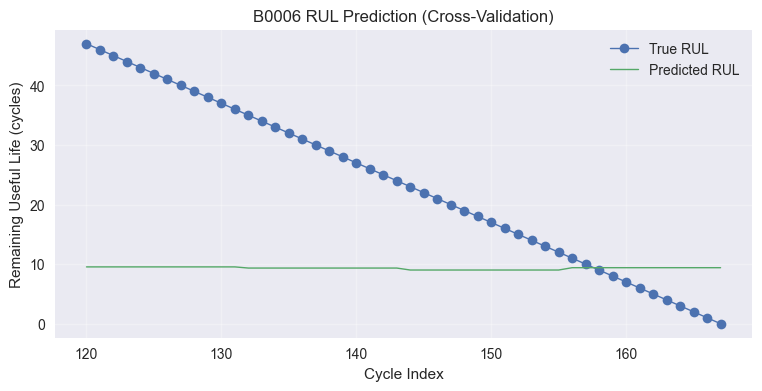

In [152]:
# 교차 검증 예측과 실제 RUL 비교 시각화 준비
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(cv_results["cycle_index"], cv_results["rul_cycle"], label="True RUL", marker="o", linewidth=1)
ax.plot(cv_results["cycle_index"], cv_results["pred_rul"], label="Predicted RUL", marker="x", linewidth=1)
ax.set_xlabel("Cycle Index")
ax.set_ylabel("Remaining Useful Life (cycles)")
ax.set_title(f"{battery_id} RUL Prediction (Cross-Validation)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


In [153]:
# 폴드별 검증 지표 요약
summary_rows = []
for fold_id, result in enumerate(fold_results, 1):
    mae = np.mean(np.abs(result["pred_rul"] - result["target_rul"]))
    rmse = np.sqrt(np.mean((result["pred_rul"] - result["target_rul"]) ** 2))
    summary_rows.append({"fold": fold_id, "best_val_loss": result["best_val"], "val_mae": mae, "val_rmse": rmse})

cv_summary = pd.DataFrame(summary_rows)
cv_summary


,fold,best_val_loss,val_mae,val_rmse
0,1,1033.449829,31.960981,32.146862
1,2,418.222504,20.156530,20.449995
2,3,83.975800,8.486147,9.161398
3,4,11.963634,4.269610,5.211641


## 다음 단계 제안

- 교차 검증이 끝난 뒤에는 마지막 폴드를 포함해 전체 데이터로 재학습하여 최종 모델을 만들 수 있습니다.
- `WEIGHT_ALPHA`, `LOSS_WEIGHTS`, `TRAIN_WINDOW` 등의 하이퍼파라미터를 조정하며 성능을 비교해 보세요.
- Capacity, Re, Rct 등을 별도 스칼라 입력으로 결합하거나, 다른 네트워크 구조(GRU, 1D CNN)와 비교 실험을 진행해볼 수 있습니다.